# Configuration

In [1]:
from secScraper import *
import sys

if sys.version_info[0] < 3 or sys.version_info[1] < 6:
    raise Exception("Must be using Python >= 3.6 due to reliance on ordered default dict.")
else:
    version = "[INFO] Running python {}.{}.{}".format(*sys.version_info[:3])
    if display.run_from_ipython():
        %load_ext autoreload
        %autoreload 2
        %matplotlib notebook
        version += " for ipython" if display.run_from_ipython() else ""
    print("[INFO] Running python {}.{}.{} (>= python 3.6)".format(*sys.version_info[:3]))

[nltk_data] Error loading stopwords: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>
[nltk_data] Error loading punkt: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>
[nltk_data] Error loading wordnet: <urlopen error [Errno -2] Name or
[nltk_data]     service not known>


[INFO] Running python 3.7.3 (>= python 3.6)


## Packages to import

In [2]:
import glob
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.ioff()

import os
import csv
from datetime import datetime
import re
from tqdm import tqdm
import multiprocessing as mp
from collections import OrderedDict
import time
import pandas as pd
import argparse
import psycopg2
import ast
import copy

# Spark
# import findspark
# findspark.init('/home/alex/spark-2.4.4-bin-hadoop2.7')
import pyspark

### Set the nb of processes to use based on cmd line arguments/setting

In [3]:
if display.run_from_ipython():
    nb_processes_requested = mp.cpu_count()  # From IPython, fixed setting
    nb_processes_requested = 1 # From IPython, fixed setting
else:
    ap = argparse.ArgumentParser()
    ap.add_argument("-p", "--processes", type=int, default=1, help="Number of processes launched to process the reports.")
    args = vars(ap.parse_args())
    nb_processes_requested = args["processes"]
    if not 1 <= nb_processes_requested <= mp.cpu_count():
        raise ValueError('[ERROR] Number of processes requested is incorrect.\
                         \n{} CPUs are available on this machine, please select a number of processes between 1 and {}'
                         .format(mp.cpu_count()))

## Settings dictionary

In [4]:
home = os.path.expanduser("~")
_s = {
    'path_stage_1_data': os.path.join(home, 'Desktop/filtered_text_data/nd_data/'),
    'path_stock_database': os.path.join(home, 'Desktop/Insight project/Database/Ticker_stock_price.csv'),
    'path_filtered_stock_data': os.path.join(home, 'Desktop/Insight project/Database/filtered_stock_data.csv'),
    'path_stock_indexes': os.path.join(home, 'Desktop/Insight project/Database/Indexes/'),
    'path_filtered_index_data': os.path.join(home, 'Desktop/Insight project/Database/Indexes/filtered_index_data.csv'),
    'path_lookup': os.path.join(home, 'Desktop/Insight project/Database/lookup.csv'),
    'path_filtered_lookup': os.path.join(home, 'Desktop/Insight project/Database/filtered_lookup.csv'),
    'path_master_dictionary': os.path.join(home, 'Desktop/Insight project/Database/LoughranMcDonald_MasterDictionary_2018.csv'),
    'path_dump_crsp': os.path.join(home, 'Desktop/Insight project/Database/dump_crsp_merged.txt'),
    'path_output_folder': os.path.join(home, 'Desktop/Insight project/Outputs'),
    'path_dump_cik_scores': os.path.join(home, 'Desktop/Insight project/Outputs/dump_cik_scores.csv'),
    'path_dump_pf_values': os.path.join(home, 'Desktop/Insight project/Outputs/dump_pf_values.csv'),
    'path_dump_master_dict': os.path.join(home, 'Desktop/Insight project/Outputs/dump_master_dict.csv'),
    'metrics': ['diff_sk_cosine_tf', 'diff_jaccard'],
    'stop_words': False,
    'lemmatize': False,
    'differentiation_mode': 'quarterly',
    'pf_balancing': 'unbalanced',
    'time_range': [(2012, 1), (2014, 4)],
    'bin_count': 5,
    'tax_rate': 0,
    'histogram_date_span_ratio': 0.5,
    'report_type': ['10-K', '10-Q'],
    'sections_to_parse_10k': [],
    'sections_to_parse_10q': [],
    'type_daily_price': 'closing'
}

In [5]:
_s['pf_init_value'] = 100.0  # In points
_s['epsilon'] = 0.001  # Rounding error
# Calculated settings
_s['list_qtr'] = qtrs.create_qtr_list(_s['time_range'])

if _s['bin_count'] == 5:
    _s['bin_labels'] = ['Q'+str(n) for n in range(1, _s['bin_count']+1)]
elif _s['bin_count'] == 10:
    _s['bin_labels'] = ['D'+str(n) for n in range(1, _s['bin_count']+1)]
else:
    raise ValueError('[ERROR] This type of bin has not been implemented yet.')

# Create diff metrics and sing metrics
_s['diff_metrics'] = [m for m in _s['metrics'] if m[:4] == 'diff']
_s['sing_metrics'] = [m for m in _s['metrics'] if m[:4] == 'sing']
# Reports considered to calculate the differences
if _s['differentiation_mode'] == 'quarterly':
    _s['lag'] = 1
    _s['sections_to_parse_10k'] = ['1a', '3', '7', '7a', '9a']
    _s['sections_to_parse_10q'] = ['_i_2', '_i_3', '_i_4', 'ii_1', 'ii_1a']
elif _s['differentiation_mode'] == 'yearly':
    _s['lag'] = 4
    _s['sections_to_parse_10k'] = ['1a', '3', '7', '7a', '9a']
    _s['sections_to_parse_10q'] = ['_i_2', '_i_3', '_i_4', 'ii_1', 'ii_1a']

_s['common_quarterly_sections'] = {
        '10-K': ['1a', '3', '7', '7a', '9a'],
        '10-Q': ['ii_1a', 'ii_1', '_i_2', '_i_3', '_i_4']
}  # Exhibits are not taken into account
"""_s['common_yearly_sections'] = {
    '10-K': ['1', '1a', '1b', '2', '3', '4', '5', '6', '7', '7a', '8', '9', '9a', '9b', '10', '11', '12', '13', '14', '15'],
    '10-Q': ['_i_1', '_i_2', '_i_3', '_i_4', 'ii_1', 'ii_1a', 'ii_2', 'ii_3', 'ii_4', 'ii_5', 'ii_6']
}"""
_s['common_yearly_sections'] = {
    '10-K': ['7'],
    '10-Q': ['_i_2']
}  # Take into account 

In [6]:
# Transfer s to a read only dict
read_only_dict = pre_processing.ReadOnlyDict()
for key in _s:  # Brute force copy
    read_only_dict[key] = _s[key]
s = read_only_dict  # Copy back
s.set_read_state(read_only=True)  # Set as read only

# Load external tables

In [7]:
connector = psycopg2.connect(host="localhost", dbname="postgres", user="postgres", password="1")

In [8]:
postgres.settings_to_postgres(connector, s)

100%|██████████| 35/35 [00:00<00:00, 1347.78it/s]

[INFO] Deleted table settings
[INFO] Creating the following table:
CREATE TABLE settings(IDX integer PRIMARY KEY,KEY text,VALUE text)


## Extract the list of CIK for which we have complete data

The main problem in our case is that we have 3 different database to play with:
1. The SEC provides information based on the CIK of the entity
2. Given that the CIK is used by no one else, we use a lookup table to transform that into tickers. But we do not have all the correspondances, so the list of useful CIK is shrunk.
3. Finally, we only have stock prices for so many tickers. So that shrinks the CIK list even further.

We end up with a reduced list of CIK that we can play with.

### Load the sentiment analysis dictionary

In [9]:
lm_dictionary = Load_MasterDictionary.load_masterdictionary(s['path_master_dictionary'], True)

 ...Loading Master Dictionary 85000
Master Dictionary loaded from file: 
  /home/alex/Desktop/Insight project/Database/LoughranMcDonald_MasterDictionary_2018.csv
  86,486 words loaded in master_dictionary.



### Find all the unique CIK from the SEC filings

In [10]:
cik_path = pre_processing.load_cik_path(s)

[INFO] Loaded 395,773 10-X
[INFO] Shrunk to 350,283 ['10-K', '10-Q']


 56%|█████▌    | 194629/350283 [00:00<00:00, 955082.81it/s]

[INFO] Found 18,009 unique CIK in master index


100%|██████████| 350283/350283 [00:00<00:00, 996443.65it/s]

[INFO] cik_path contains data on 18,009 CIK numbers


### Get the largest {CIK: ticker} possible given our lookup table

In [11]:
lookup, reverse_lookup = postgres.retrieve_lookup(connector)
print("[INFO] Loaded {:,} CIK/Tickers correspondances.".format(len(lookup)))

SELECT * FROM lookup;
[INFO] Loaded 13,738 CIK/Tickers correspondances.


In [12]:
cik_path, lookup = pre_processing.intersection_sec_lookup(cik_path, lookup)
print("[INFO] Intersected SEC & lookup.")
print("cik_path: {:,} CIK | lookup: {:,} CIK"
      .format(len(cik_path), len(lookup)))

[INFO] Intersected SEC & lookup.
cik_path: 9,547 CIK | lookup: 9,547 CIK


In [13]:
lookup[851968]

'MHK'

### Load stock data and drop all CIKs for which we don't have data

In [14]:
# Load all stock prices
stock_data = postgres.retrieve_all_stock_data(connector, 'stock_data')

SELECT * FROM stock_data;


100%|██████████| 2285837/2285837 [00:02<00:00, 850796.25it/s] 


In [15]:
lookup, stock_data = pre_processing.intersection_lookup_stock(lookup, stock_data)
print("[INFO] Intersected lookup & stock data.")
print("lookup: {:,} tickers | stock_data: {:,} tickers"
      .format(len(lookup.values()), len(stock_data)))

3389
[INFO] Intersected lookup & stock data.
lookup: 3,524 tickers | stock_data: 3,389 tickers


### Load stock indexes - will serve as benchmark later on

In [16]:
index_data = postgres.retrieve_all_stock_data(connector, 'index_data')
print("[INFO] Loaded the following index data:", list(index_data.keys()))

100%|██████████| 26373/26373 [00:00<00:00, 1286102.38it/s]

SELECT * FROM index_data;
[INFO] Loaded the following index data: ['IXIC', 'SPX', 'DJI', 'RUT']


## Back propagate these intersection all the way to cik_path

Technically, we have just done it for lookup. So we only need to re-run an intersection for lookup and sec.

In [17]:
cik_path, lookup = pre_processing.intersection_sec_lookup(cik_path, lookup)
print("[INFO] Intersected SEC & lookup.")
print("cik_path: {:,} CIK | lookup: {:,} CIK"
      .format(len(cik_path), len(lookup)))

[INFO] Intersected SEC & lookup.
cik_path: 3,524 CIK | lookup: 3,524 CIK


## Sanity check

At this point, cik_path and lookup should have the same number of keys as the CIK is unique in the path database.

However, multiple CIK can redirect to the same ticker if the company changed its ticker over time. That should be a very limited amount of cases though.

In [18]:
assert cik_path.keys() == lookup.keys()
assert len(set(lookup.values())) == len(set(stock_data.keys()))

At that point, we have a {CIK: ticker} for which the stock is known, which will enable comparison and all down the road.

## Review all CIKs: make sure there is only one submission per quarter

In this section, the goal is to build a list of CIK that will successfully be parsed for the time_range considered.
It should be trivial for a vast majority of the CIK, but ideally there should be only one document per quarter for each CIK from the moment they are listed to the moment they are delisted.

In [19]:
# Create the list of quarters to consider
cik_path = pre_processing.review_cik_publications(cik_path, s)
print("[INFO] Removed all the CIK that did not have one report per quarter.")
print("cik_dict: {:,} CIK".format(len(cik_path)))

100%|██████████| 3524/3524 [00:00<00:00, 9335.02it/s]


[INFO] 945 CIKs caused trouble
[INFO] Removed all the CIK that did not have one report per quarter.
cik_dict: 2,579 CIK


In [20]:
print("[INFO] We are left with {:,} CIKs that meet our requirements:".format(len(cik_path)))
print("- The ticker can be looked up in the CIK/ticker tabke")
print("- The stock data is available for that ticker")
print("- There is one and only one report per quarter")

[INFO] We are left with 2,579 CIKs that meet our requirements:
- The ticker can be looked up in the CIK/ticker tabke
- The stock data is available for that ticker
- There is one and only one report per quarter


## Dump all the data to postgres
This is done so that the Flask webapp can retrieve the settings that were used at a later time.

In [21]:
print(list(cik_path.keys()).index(10456))  # Find BAX

680


connector = psycopg2.connect(host="localhost", dbname="postgres", user="postgres", password="1")

postgres.settings_to_postgres(connector, s)

header_lookup = (('CIK', 'integer'), ('TICKER', 'text'))
postgres.lookup_to_postgres(connector, lookup, header_lookup)

header = (('TICKER', 'text'), ('TIMESTAMP', 'date'), 
          ('ASK', 'float'), ('MARKET_CAP', 'float'))
path = os.path.join(home, 'Desktop/Insight project/Database/stock_data_filtered.csv')
postgres.stock_data_csv_to_postgres(connector, path, header)

stock_data_2 = postgres.retrieve_stock_data(connector)

# Parse files

Now we have a list of CIK that should make it until the end. It is time to open the relevant reports and start parsing. This step takes a lot of time and can get arbitrarily long as the metrics get fancier.

You do not want to keep in RAM all the parsed data. However, there are only ~100 quarters for which we have data and the stage 2 files are no more than 1 Mb in size (Apple seems to top out at ~ 325 kb). So 100 Mb per core + others, that's definitely doable. More cores will use more RAM, but the usage remains reasonable.

We use multiprocessing to go through N CIK at once but a single core is dedicated to going through a given CIK for the specified time_range. Such a core can be running for a while if the company has been in business for the whole time_range and publish a lot of text data in its 10-K.

In [22]:
try:
    sc.stop()
except:
    pass
nb_processes_requested = 8

In [23]:
nb_processes_requested = 8

In [24]:
# Processing the reports will be done in parrallel in a random order
# Settings in s are cast to dict for pickling - the custom class is not supported
nb_cik_to_process = 100
cik_path = {k: cik_path[k] for k in cik_path.keys() if k in list(cik_path.keys())[:nb_cik_to_process]}

# print(list(cik_path.keys()).index(10456))  # Find BAX
cik_scores = {k: 0 for k in cik_path.keys()}  # Organized by ticker
data_to_process = ([k, v, {**s}, lm_dictionary] for k, v in cik_path.items())
assert cik_path.keys() == cik_scores.keys()
#print(data_to_process)
#result = process_cik(data_to_process[0])
#cik_perf[result[0]] = result[1]
#print(cik_perf)
#assert 0
processing_stats = [0, 0, 0, 0, 0, 0]
#qtr_metric_result = {key: [] for key in s['list_qtr']}
if nb_processes_requested > 1:
    with mp.Pool(processes=nb_processes_requested) as p:
    #with mp.Pool(processes=min(mp.cpu_count(), 1)) as p:
        print("[INFO] Starting a pool of {} workers".format(nb_processes_requested))

        with tqdm(total=nb_cik_to_process) as pbar:
            for i, value in tqdm(enumerate(p.imap_unordered(processing.process_cik, data_to_process))):
                pbar.update()
                #qtr = list_qtr[i]
                # Each quarter gets a few metrics
                if value[1] == {}:
                    # The parsing failed
                    del cik_scores[value[0]]
                else:
                    cik_scores[value[0]] = value[1]
                processing_stats[value[2]] += 1

elif nb_processes_requested == 1:
    print("[INFO] Running on {} core (multiprocessing is off)".format(nb_processes_requested))
    # print(list(data_to_process))
    with tqdm(total=nb_cik_to_process) as pbar:
        for i, value in tqdm(enumerate(map(processing.process_cik, data_to_process))):
            pbar.update()
            #qtr = list_qtr[i]
            # Each quarter gets a few metrics
            if value[1] == {}:
                # The parsing failed
                del cik_scores[value[0]]
            else:
                cik_scores[value[0]] = value[1]
            processing_stats[value[2]] += 1

elif nb_processes_requested == 0:
    # Spark mode!!
    print("[INFO] Running with Spark")
    sc = pyspark.SparkContext(appName="model_calculations")
    print("[INFO] Context started")
    spark_result = sc.parallelize(data_to_process).map(processing.process_cik)
    spark_result = spark_result.take(nb_cik_to_process)
    sc.stop()
    
    # Process the result
    with tqdm(total=nb_cik_to_process) as pbar:
        for i, value in tqdm(enumerate(spark_result)):
            pbar.update()
            #qtr = list_qtr[i]
            # Each quarter gets a few metrics
            if value[1] == {}:
                # The parsing failed
                del cik_scores[value[0]]
            else:
                cik_scores[value[0]] = value[1]
            processing_stats[value[2]] += 1
           
        #qtr_metric_result[value['0']['qtr']] = value

print("[INFO] {} CIK were successfully processed - {}/{} CIK failed.".format(len(cik_scores), len(cik_path)-len(cik_scores), len(cik_path)))
print("Detailed stats and error codes:", processing_stats)

  0%|          | 0/100 [00:00<?, ?it/s]


[INFO] Starting a pool of 8 workers


  2%|▏         | 2/100 [00:04<03:58,  2.44s/it]
2it [00:03,  2.26s/it]

[ERROR] list index out of range in parser.clean_first_markers (10-Q)
This is the res
 {'_i_1': [(6476, 6498)], '_i_2': [(29598, 29622)], '_i_3': [(64460, 64485)], '_i_4': [(65862, 65884)], 'ii_1': [(67300, 67318)], 'ii_1a': [], 'ii_2': [(67891, 67916)], 'ii_4': [(68040, 68057)], 'ii_5': [(68088, 68110)], 'ii_6': [(68175, 68197)]}


  3%|▎         | 3/100 [00:05<03:27,  2.14s/it]
3it [00:05,  2.02s/it]

[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2012/QTR2/20120504_10-Q_edgar_data_1171486_0001193125-12-210830_1.txt failed parsing


 18%|█▊        | 18/100 [00:25<02:11,  1.60s/it]
18it [00:25,  1.60s/it]

[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'1': [], '1a': [], '1b': [], '2': [], '3': [], '4': [], '5': [], '6': [], '7': [], '7a': [], '8': [], '9': [], '9a': [], '9b': [], '10': [], '11': [], '12': [], '13': [], '14': [], '15': []}


 19%|█▉        | 19/100 [00:26<01:53,  1.40s/it]

[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2012/QTR1/20120306_10-K_edgar_data_892986_0001047469-12-002166_1.txt failed parsing



 21%|██        | 21/100 [00:28<01:39,  1.26s/it]
21it [00:28,  1.26s/it]

[ERROR] list index out of range in parser.clean_first_markers (10-Q)
This is the res


 22%|██▏       | 22/100 [00:29<01:28,  1.13s/it]

 {'_i_1': [(4105, 4128)], '_i_2': [(35180, 35202)], '_i_3': [(50226, 50249)], '_i_4': [(52879, 52899)], 'ii_1a': [], 'ii_6': [(53608, 53629)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2012/QTR2/20120509_10-Q_edgar_data_712770_0001104659-12-035186_1.txt failed parsing



 31%|███       | 31/100 [00:44<02:15,  1.97s/it]
31it [00:44,  1.95s/it]

[ERROR] list index out of range in parser.clean_first_markers (10-K)
This is the res


 32%|███▏      | 32/100 [00:45<01:51,  1.64s/it]

 {'1': [(231317, 231336)], '1a': [], '1b': [(121705, 121725)], '2': [(121750, 121769), (231342, 231363)], '3': [(5377, 5396), (204218, 204232)], '5': [(5509, 5529), (208048, 208063)], '6': [(5652, 5674), (230680, 230697)], '7': [(5706, 5730), (231074, 231095), (231469, 231488)], '7a': [(5827, 5854), (261627, 261649)], '8': [(5918, 5941), (36499, 36518), (261714, 261732)], '9': [(5992, 6013), (261987, 262003)], '9a': [(6111, 6134)], '9b': [(6166, 6186), (267075, 267090)], '10': [(6244, 6268), (267122, 267141)], '11': [(6330, 6354), (267722, 267741)], '12': [(6384, 6407), (267885, 267903)], '13': [(6510, 6532), (268116, 268133)], '14': [(6619, 6643), (268330, 268349)], '15': [(6719, 6742), (268519, 268537)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2012/QTR1/20120309_10-K_edgar_data_1319009_0001144204-12-014022_1.txt failed parsing



 33%|███▎      | 33/100 [00:46<01:34,  1.41s/it]
33it [00:46,  1.40s/it]

[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2012/QTR2/20120501_10-Q_edgar_data_82020_0001104659-12-031348_1.txt failed parsing


 42%|████▏     | 42/100 [01:00<01:25,  1.48s/it]


[ERROR] Here is full_sect: |[]|
[ERROR] Original res: {'_i_1': [], '_i_2': [], '_i_3': [], '_i_4': [], 'ii_1': [], 'ii_1a': [], 'ii_2': [], 'ii_3': [], 'ii_4': [], 'ii_5': [], 'ii_6': []}


42it [01:00,  1.49s/it]

[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2012/QTR2/20120420_10-Q_edgar_data_1065088_0001065088-12-000037_1.txt failed parsing


 43%|████▎     | 43/100 [01:01<01:12,  1.28s/it]
43it [01:00,  1.27s/it]

[ERROR] list index out of range in parser.clean_first_markers (10-K)
This is the res


 46%|████▌     | 46/100 [01:02<00:56,  1.05s/it]

 {'1': [(9333, 9353)], '1a': [(25142, 25160)], '1b': [(65382, 65406)], '3': [(251900, 251916)], '5': [], '6': [(87118, 87138)], '7': [(88778, 88800)], '7a': [(267461, 267486)], '8': [(272349, 272370)], '9': [(431923, 431942)], '9a': [(432047, 432068)], '9b': [(434449, 434467)], '10': [(434573, 434595)], '11': [(435174, 435196)], '12': [(435591, 435612)], '13': [(436081, 436101)], '14': [(436471, 436493)], '15': [(436898, 436919)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2012/QTR1/20120312_10-K_edgar_data_1056903_0001104659-12-017424_1.txt failed parsing



 54%|█████▍    | 54/100 [01:15<00:53,  1.17s/it]
54it [01:15,  1.16s/it]

[ERROR] list index out of range in parser.clean_first_markers (10-K)


 55%|█████▌    | 55/100 [01:16<00:47,  1.05s/it]

This is the res


 {'1': [(10171, 10200)], '1a': [(126961, 126978)], '1b': [(285435, 285458)], '2': [(285485, 285516)], '3': [(286210, 286236)], '5': [(287342, 287368)], '6': [(303300, 303320)], '7': [(304313, 304334)], '7a': [(360731, 360764)], '8': [(362655, 362685)], '9': [(362853, 362880)], '9b': [(365776, 365802)], '10': [(368178, 368207)], '11': [], '12': [(416989, 417018)], '13': [(394140, 394158), (424567, 424586)], '14': [(429294, 429325)], '15': [(430344, 430374)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2014/QTR1/20140324_10-K_edgar_data_1515673_0001564590-14-000963_1.txt failed parsing


 61%|██████    | 61/100 [01:21<00:37,  1.04it/s]
61it [01:21,  1.04it/s]

[ERROR] list index out of range in parser.clean_first_markers (10-Q)
This is the res
 {'_i_1': [(4197, 4246)], '_i_2': [(34658, 34708)], '_i_3': [(74737, 74790)], '_i_4': [(75390, 75439)], 'ii_1': [(76437, 76467)], 'ii_1a': [], 'ii_6': [(4120, 4139), (77933, 77965)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2013/QTR2/20130507_10-Q_edgar_data_1474735_0001474735-13-000014_1.txt failed parsing


 84%|████████▍ | 84/100 [01:59<00:22,  1.43s/it]
84it [01:59,  1.43s/it]

[ERROR] list index out of range in parser.clean_first_markers (10-Q)
This is the res
 {'_i_1': [(4651, 4672)], '_i_2': [(47471, 47490)], '_i_3': [(118506, 118527)], '_i_4': [(121108, 121126)], 'ii_1': [(123139, 123154)], 'ii_1a': [(124112, 124127)], 'ii_2': [(124321, 124343)], 'ii_5': [], 'ii_6': [(125294, 125311)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2014/QTR3/20140801_10-Q_edgar_data_1507615_0001507615-14-000052_1.txt failed parsing


 93%|█████████▎| 93/100 [02:13<00:08,  1.24s/it]
93it [02:13,  1.24s/it]

[ERROR] list index out of range in parser.clean_first_markers (10-Q)
This is the res
 {'_i_2': [(83751, 83771)], '_i_3': [(124720, 124742)], '_i_4': [(127387, 127405)], 'ii_1': [], 'ii_1a': [(6219, 6234), (130859, 130874), (130952, 130967)], 'ii_2': [(137072, 137094)], 'ii_6': [(138278, 138296)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2014/QTR4/20141107_10-Q_edgar_data_1319229_0001558370-14-000345_1.txt failed parsing


 94%|█████████▍| 94/100 [02:14<00:07,  1.17s/it]
94it [02:14,  1.17s/it]

[ERROR] list index out of range in parser.clean_first_markers (10-K)
This is the res
 {'1': [(8529, 8547), (12841, 12901)], '1a': [(8548, 8564), (53118, 53133), (53392, 53407)], '1b': [(170981, 171044)], '7': [(179133, 179153)], '7a': [], '9a': [(270004, 270065)], '9b': [(274665, 274723)], '15': [(41107, 41126), (119314, 119333), (237548, 237567), (241180, 241199), (260234, 260253), (269735, 269754)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2014/QTR1/20140311_10-K_edgar_data_1352010_0001352010-14-000007_1.txt failed parsing


 95%|█████████▌| 95/100 [02:15<00:05,  1.08s/it]
95it [02:15,  1.08s/it]

[ERROR] list index out of range in parser.clean_first_markers (10-K)
This is the res
 {'1': [(8221, 8239)], '3': [(242183, 242198)], '5': [(268236, 268252)], '7': [], '15': [(269788, 269812)]}
[WARNING] /home/alex/Desktop/filtered_text_data/nd_data/2014/QTR1/20140210_10-K_edgar_data_24741_0001308179-14-000032_1.txt failed parsing


100%|██████████| 100/100 [02:23<00:00,  2.14s/it]
100it [02:22,  2.14s/it]

[INFO] 87 CIK were successfully processed - 13/100 CIK failed.
Detailed stats and error codes: [87, 13, 0, 0, 0, 0]


# Post-processing - Welcome to the gettho

## Flip the result dictionary to present a per qtr view

In [25]:
def make_quintiles(qtr_data, s, winsorize = 0.01, verbose=False):
    # 1. Isolate the non zero CIKs
    non_zero_ciks = {cik: v for cik, v in qtr_data.items() if v != {}}
    if verbose:
        print("[INFO] Non zero ciks: {}/{}".format(len(non_zero_ciks), len(qtr_data)))
    sorted_ciks = sorted(non_zero_ciks, key=lambda x: non_zero_ciks[x]['total'] if non_zero_ciks[x] != {} else 0)

    # 2. Winsorize to remove outliers
    start = round(len(sorted_ciks)*winsorize)  # Output an int
    end = len(sorted_ciks) - start  # Stays an int
    sorted_ciks = sorted_ciks[start:end]
    if verbose:
        print("[INFO] Left with {}/{} elements after winsorizing".format(len(sorted_ciks), len(qtr_data)))

    # 3. Make quintiles/deciles
    splits = np.linspace(0, len(sorted_ciks), s['bin_count']+1, endpoint=True, dtype=np.int)
    quintiles = dict()
    # Make sure bins are in increasing order: Q1 -> Q5. Otherwise, sorted_ciks' order needs to be reversed.
    assert int(s['bin_labels'][-1][1:]) > int(s['bin_labels'][0][1:])
    for idx, l in enumerate(s['bin_labels']):
        quintiles[l] = {cik: qtr_data[cik] for cik in sorted_ciks[splits[idx]:splits[idx+1]]}
    
    # Sanity check: Verify that the quintiles worked as expected. O(N**2).
    for idx in range(1, len(s['bin_labels'])):
        for cik in quintiles[s['bin_labels'][idx]]:
            for cik_previous in quintiles[s['bin_labels'][idx-1]]:
                try:
                    assert qtr_data[cik]['total'] >= qtr_data[cik_previous]['total']
                except:
                    print(cik, qtr_data[cik])
                    print(cik_previous, qtr_data[cik_previous])
                    raise
     
    return quintiles

In [26]:
metric_scores = {m: {qtr: {cik: {} for cik in cik_scores} for qtr in s['list_qtr'][s['lag']:]} for m in s['metrics']}

In [27]:
pnf = []
for cik in tqdm(cik_scores):
    for qtr in cik_scores[cik]:
        _, _, flag_price_found = post_processing.get_share_price(cik, qtr, lookup, stock_data)
        if not flag_price_found:
            print("[WARNING] There is no stock data for {} during {}".format(cik, qtr))
            pnf.append(cik)
            break  # That CIK from cik_scores will be left unpopulated and subsequently discarded
        sections = [section for section in cik_scores[cik][qtr] if section != '0' and section != 'total']
        for section in sections:
            for m in s['metrics']:
                metric_scores[m][qtr][cik][section] = cik_scores[cik][qtr][section][m]
                metric_scores[m][qtr][cik]['total'] = cik_scores[cik][qtr]['total'][m]
                # metric_scores[m][qtr][cik]['0'] = cik_scores[cik][qtr]['0']
print("Unique cik", set(pnf))

100%|██████████| 87/87 [00:00<00:00, 2929.90it/s]

[WARNING] There is no stock data for 712771 during (2014, 3)
[WARNING] There is no stock data for 1376339 during (2012, 2)
[WARNING] There is no stock data for 352363 during (2012, 2)
[WARNING] There is no stock data for 778438 during (2014, 1)
[WARNING] There is no stock data for 1294538 during (2012, 3)
Unique cik {712771, 778438, 1294538, 352363, 1376339}


In [28]:
print("[INFO] Number of companies that do not have data for a given qtr.")
print("This is because they are listed later in the time_range")
for qtr in s['list_qtr'][s['lag']:]:
    print(qtr, "{}/{}".format(len([cik for cik in metric_scores['diff_jaccard'][qtr] 
                    if metric_scores['diff_jaccard'][qtr][cik] == {}]), len(cik_scores)))

[INFO] Number of companies that do not have data for a given qtr.
This is because they are listed later in the time_range
(2012, 2) 19/87
(2012, 3) 17/87
(2012, 4) 20/87
(2013, 1) 21/87
(2013, 2) 20/87
(2013, 3) 16/87
(2013, 4) 11/87
(2014, 1) 10/87
(2014, 2) 10/87
(2014, 3) 11/87
(2014, 4) 13/87


In [29]:
# metric_scores['diff_jaccard'][(2014, 4)]  # Before
def metrics_correlation(metric_scores):
    data = []
    for m in s['diff_metrics']:
        flattened_metric = []
        for qtr in s['list_qtr'][s['lag']:]:
            for cik in metric_scores[m][qtr]:
                if metric_scores[m][qtr][cik] != {}:
                    flattened_metric.append(metric_scores[m][qtr][cik]['total'])
        data.append(flattened_metric)
    df = pd.DataFrame(zip(*data), columns=s['diff_metrics'])
    return df

In [30]:
df = metrics_correlation(metric_scores)

In [31]:
df.head()

,diff_sk_cosine_tf,diff_jaccard
0,0.153058,0.006886
1,0.663549,0.400043
2,0.264091,0.020048
3,0.592997,0.217140
4,0.848348,0.378089


In [32]:
df.corr()

,diff_sk_cosine_tf,diff_jaccard
diff_sk_cosine_tf,1.000000,0.921175
diff_jaccard,0.921175,1.000000


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 789 entries, 0 to 788
Data columns (total 2 columns):
diff_sk_cosine_tf    789 non-null float64
diff_jaccard         789 non-null float64
dtypes: float64(2)
memory usage: 12.4 KB


In [34]:
# Create the quintiles - do not re-run that cell or it will crash!
for m in s['metrics']:
    for qtr in s['list_qtr'][s['lag']:]:
        metric_scores[m][qtr] = make_quintiles(metric_scores[m][qtr], s)

In [35]:
metric_scores['diff_jaccard'].keys()

dict_keys([(2012, 2), (2012, 3), (2012, 4), (2013, 1), (2013, 2), (2013, 3), (2013, 4), (2014, 1), (2014, 2), (2014, 3), (2014, 4)])

In [36]:
# Sanity check: Verify that there are no CIK left for which we do not have stock prices.
pnf = []
for m in s['metrics']:
    for qtr in s['list_qtr'][s['lag']:]:
        for l in s['bin_labels']:
            for cik in metric_scores[m][qtr][l]:
                _, _, flag_price_found = post_processing.get_share_price(cik, qtr, lookup, stock_data)
                if not flag_price_found:
                    print("[WARNING] [{}] No stock data for {} during {}".format(m, cik, qtr))
                    pnf.append(cik)
print("Unique cik", set(pnf))           

Unique cik set()


In [37]:
metric_scores['diff_jaccard'][(2013, 1)]  # After

{'Q1': {851968: {'1a': 0.0009041591320072332,
   'total': 0.007628985026373538,
   '3': 0.006920415224913495,
   '7': 0.0072992700729927005,
   '7a': 0.003912800447177194,
   '9a': 0.01910828025477707},
  1261694: {'1a': 0.0005449591280653951,
   'total': 0.008754270599730163,
   '3': 0.001520912547528517,
   '7': 0.006056527590847914,
   '7a': 0.024896265560165973,
   '9a': 0.010752688172043012},
  917520: {'1a': 0.0004950495049504951,
   'total': 0.010838747068026757,
   '3': 0.007352941176470588,
   '7': 0.00508646998982706,
   '7a': 0.023715415019762844,
   '9a': 0.017543859649122806},
  884905: {'1a': 0.0012360939431396785,
   'total': 0.014134359135284326,
   '3': 0.02631578947368421,
   '7': 0.00591016548463357,
   '7a': 0.020066889632107024,
   '9a': 0.017142857142857144},
  860413: {'1a': 0.013199245757385292,
   'total': 0.014536631809069599,
   '3': 0.021904761904761906,
   '7': 0.00496031746031746,
   '7a': 0.01488833746898263,
   '9a': 0.01773049645390071},
  1179929: {'1a

In [38]:
# Introduce the pf_values
pf_values = {m: {qtr: {} for qtr in metric_scores[m]} for m in metric_scores}

In [39]:
# This first pass populates the pf with the relevant ciks.

for m in s['metrics']:
    for idx, qtr in enumerate(s['list_qtr'][s['lag']:]):
        if idx == 0:  # qtr == s['list_qtr'][s['lag']]
            data = {l: {cik: [] for cik in metric_scores[m][qtr][l]} for l in s['bin_labels']}
            pf_values[m][qtr]['incoming_compo'] = {}  # Not useful. Will be copied later
            pf_values[m][qtr]['incoming_value'] = {l: s['pf_init_value'] for l in s['bin_labels']}  # Not really useful
            pf_values[m][qtr]['new_value'] = {l: s['pf_init_value'] for l in s['bin_labels']}
            pf_values[m][qtr]['new_compo'] = data
            
        elif 0 < idx:  # not the first qtr
            data = {l: {cik: [] for cik in metric_scores[m][qtr][l]} for l in s['bin_labels']}
            previous_qtr = s['list_qtr'][s['lag']:][idx-1]
            # No need to populate the incoming_value. They will be calculated gradually
            # pf_values[m][qtr]['incoming_compo'] = copy.deepcopy(pf_values[m][previous_qtr]['new_compo'])
            pf_values[m][qtr]['incoming_compo'] = {}
            pf_values[m][qtr]['incoming_value'] = {l: 0 for l in s['bin_labels']}
            pf_values[m][qtr]['new_value'] = {l: 0 for l in s['bin_labels']}
            pf_values[m][qtr]['new_compo'] = data  # Common with idx == 0 case

In [40]:
pf_values['diff_jaccard'][(2013, 2)]

{'incoming_compo': {},
 'incoming_value': {'Q1': 0, 'Q2': 0, 'Q3': 0, 'Q4': 0, 'Q5': 0},
 'new_value': {'Q1': 0, 'Q2': 0, 'Q3': 0, 'Q4': 0, 'Q5': 0},
 'new_compo': {'Q1': {49196: [],
   884905: [],
   860413: [],
   1179929: [],
   1368265: [],
   1056923: [],
   811156: [],
   319654: [],
   1433660: [],
   106535: [],
   1171500: [],
   1171662: [],
   712771: []},
  'Q2': {1040719: [],
   1163370: [],
   40987: [],
   1032208: [],
   352541: [],
   1040593: [],
   884887: [],
   1073431: [],
   106640: [],
   106532: [],
   704532: [],
   90185: [],
   57528: []},
  'Q3': {98362: [],
   1179755: [],
   1212545: [],
   1065280: [],
   1532063: [],
   73756: [],
   868671: [],
   778438: [],
   1089819: [],
   1466593: [],
   1441849: [],
   1122304: [],
   1016125: []},
  'Q4': {1490983: [],
   1130591: [],
   1466538: [],
   1163348: [],
   729237: [],
   1138951: [],
   1392972: [],
   1220754: [],
   1556766: [],
   1057058: [],
   1040426: [],
   1171759: [],
   1507385: []},
  '

In [41]:
def buy_all_pf(funds, pf, lookup, stock_data, method):
    """
    Allocate a given amount of money to a portfolio. Method can be balanced (weighted by market cap) or unbalanced
    (each stock gets the same amount of money).
    """
    assert type(funds) == float
    nb_cik = len(pf)  # Nb of CIK in that bin
    sum_market_caps = 0
    
    # 1. Update the share price/market_cap for everyone
    for cik in pf:
        ticker = lookup[cik]
        share_price, market_cap, flag_price_found = post_processing.get_share_price(cik, qtr, lookup, stock_data)
        pf[cik] = [ticker, share_price, market_cap, 0, 0, 0]  # [..., share_count, $, $/funds]
        sum_market_caps += market_cap  # Needed to balance pf
    
    # 2. Second pass where we split the funds accordingly
    for cik in pf:
        # 2.1. Calculate the $/shares to purchase
        share_price = pf[cik][1]
        market_cap = pf[cik][2]
        if method == 'balanced':
            value = funds*(market_cap/sum_market_caps)  # $ amount depends on your mc
        elif method == 'unbalanced':
            value = funds*(1/nb_cik)  # $ amount is equal for all stocks
        share_count = value/share_price
        
        # 2.2. Buy the shares -> populate the pf line with the new values
        # pf[cik][3:] = [share_count, $, $/funds]
        # $ is how much funds we have put in that stock
        # $/funds is the ratio of funds in that stock to the total value of the pf
        pf[cik][3:] = share_count, value, value/funds
    
    return pf

In [42]:
def sell_all_pf(pf, lookup, stock_data):
    """
    Sell all the stocks in a portfolio. In practice, we just collect the value of the pf with the new updated share
    prices."""
    sum_stock_values = 0
    sum_market_caps = 0
    # I. First pass to update the stock price and the consequent value held 
    for cik in pf:
        # 1. Update the share price for that CIK/ticker
        share_price, market_cap, flag_price_found = post_processing.get_share_price(cik, qtr, lookup, stock_data)
        
        # 2. Update the value of that line given the new share_price
        share_count = pf[cik][3]  # This is invariant at that stage!
        updated_value = share_price*share_count
        pf[cik][1] = share_price  # Update stock price
        pf[cik][2] = market_cap  # Update market cap
        pf[cik][4] = updated_value  # Update value of that line
        sum_market_caps += market_cap
        
        # 3. Add that line to the total
        sum_stock_values += updated_value
    
    # II. Re-update all the market_cap ratios with the new value
    for cik in pf:
        updated_value = pf[cik][4]  # Updated value of that line in our pf
        pf[cik][5] = updated_value/sum_stock_values  # This ratio might have gone up or done.
        # pf[cik][5] can be useful to see what is our biggest exposure after a qtr. Might have changed.
    
    return pf, sum_stock_values

In [43]:
# Populate the pf for each cik and get overall values
for m in s['metrics']:
    for idx, qtr in enumerate(s['list_qtr'][s['lag']:]):
        if qtr == s['list_qtr'][s['lag']]:  # First quarter
            # Perform a new_compo only. Then copy to incoming_compo (not really necessary though)
            for l in s['bin_labels']:
                quintile_funds = pf_values[m][qtr]['new_value'][l]
                assert quintile_funds == 100.0
                pf = buy_all_pf(quintile_funds, pf_values[m][qtr]['new_compo'][l], lookup, stock_data, s['pf_balancing'])
                pf_values[m][qtr]['new_compo'][l] = pf
                pf_values[m][qtr]['incoming_compo'][l] = copy.deepcopy(pf)
            #print(pf_values[m][qtr]['new_compo'])
            # assert 0
        else:
            for stage in ['incoming_compo', 'new_compo']:
                if stage == 'incoming_compo':
                    for l in s['bin_labels']:
                        previous_qtr = s['list_qtr'][s['lag']:][idx-1]
                        pf_values[m][qtr][stage][l] = copy.deepcopy(pf_values[m][previous_qtr]['new_compo'][l])
                        pf, quintile_funds = sell_all_pf(pf_values[m][qtr][stage][l], lookup, stock_data)
                        pf_values[m][qtr][stage][l] = pf  # Update the incoming compo with the new prices
                        pf_values[m][qtr]['incoming_value'][l] = quintile_funds
                        pf_values[m][qtr]['new_value'][l] = quintile_funds*(1-s['tax_rate'])
                elif stage == 'new_compo':  # Take all the new_values and buy yourself a pf
                    for l in s['bin_labels']:
                        quintile_funds = pf_values[m][qtr]['new_value'][l]
                        pf = buy_all_pf(quintile_funds, pf_values[m][qtr][stage][l], lookup, stock_data, s['pf_balancing'])
                else:
                    raise ValueError('[ERROR] Stage {} undefined.'.format(stage))

In [44]:
# Sanity checks
# 1. Sum of all money invested should equate the funds
for m in s['metrics']:
    for qtr in s['list_qtr'][s['lag']:]:
        for stage in ['incoming_compo', 'new_compo']:
            for l in s['bin_labels']:
                if stage == 'incoming_compo':
                    declared_value = pf_values[m][qtr]['incoming_value'][l]
                elif stage == 'new_compo':
                    declared_value = pf_values[m][qtr]['new_value'][l]
                calculated_pf_value = 0
                for cik in pf_values[m][qtr][stage][l]:
                    calculated_pf_value += pf_values[m][qtr][stage][l][cik][4]
                try:
                    assert declared_value - s['epsilon'] < calculated_pf_value < declared_value + s['epsilon']
                except:
                    print([m],[qtr],[stage],[l])
                    print(pf_values[m][qtr]['incoming_value'])
                    print(declared_value, calculated_pf_value)
                    raise

In [45]:
pf_values['diff_jaccard'][(2013, 2)]

{'incoming_compo': {'Q1': {851968: ['MHK',
    112.32,
    7786696320,
    0.08873293510247535,
    9.96648327071003,
    0.09350608177496882],
   1261694: ['TSRA',
    18.39,
    969153000,
    0.4798685370196549,
    8.824782395791454,
    0.08279458279654486],
   917520: ['IART',
    39.01,
    1096298030,
    0.2087912851729458,
    8.144948034596615,
    0.07641634027662444],
   884905: ['PX',
    111.03,
    32837566620,
    0.07345535619090844,
    8.155748197876564,
    0.07651766798905896],
   860413: ['FIBK',
    18.8,
    346371200,
    0.5249609455776922,
    9.869265776860615,
    0.09259398202193393],
   1179929: ['MOH',
    30.75,
    1394912250,
    0.30782333927210176,
    9.465567682617129,
    0.0888064648017258],
   1368265: ['CLNE',
    12.63,
    1117906560,
    0.6297132439336369,
    7.953278270881835,
    0.07461808425061234],
   1122388: ['ELLI',
    23.32,
    609748040,
    0.29613663656334716,
    6.905906364657255,
    0.06479158472694801],
   1056923: ['D

In [46]:
def diff_vs_benchmark_ns(pf_values, index_name, index_data, diff_method, s, norm_by_index=False):
    """
    Plot a portfolio vs an index.

    :param pf_values: Value of the portfolio over time.
    :param index_name: Name of the index.
    :param index_data: Daily value of the index.
    :param s: Settings dictionary.
    :return: void
    """

    """Display an index"""
    benchmark_x = []
    benchmark_y = []
    for qtr in s['list_qtr'][s['lag']:]:
        qtr_start_date = "{}{}{}".format(str(qtr[0]), str((qtr[1]-1)*3+1).zfill(2), '01')
        qtr_start_date = datetime.strptime(qtr_start_date, '%Y%m%d').date()
        # days, _ = zip(*index_data[index_name])
        days, prices = zip(*index_data[index_name].items())
        
        # Find the nearest daily price
        for _ in range(7):
            try:
                idx = days.index(qtr_start_date)
                break
            except ValueError:  # The stock exchange was closed that day. Move to the next one.
                qtr_start_date = qtr_start_date.strftime('%Y%m%d')
                day = str(int(qtr_start_date[7]) + 1)
                qtr_start_date = qtr_start_date[:7] + day
                qtr_start_date = datetime.strptime(qtr_start_date, '%Y%m%d').date()
        try:
            benchmark_x.append(qtr_start_date)
            benchmark_y.append(prices[idx][0])  # Only one entry per timestamp
            
        except KeyError:
            raise KeyError('[ERROR] The stock exchange should not have been shut down for more than 7 days.')
    benchmark_y = [value*s['pf_init_value']/benchmark_y[0] for value in benchmark_y]
    
    """Norm by index or not?"""
    if norm_by_index:
        norm = benchmark_y
        benchmark_y = [-s['pf_init_value']]*len(norm)  # Nullify the index data
    else:
        norm = [1]*len(benchmark_y)
        # plt.plot_date(benchmark_x, benchmark_y, label=index_name, linestyle='-.', linewidth=2, ms=10, marker=',')
    benchmark = zip(benchmark_x, benchmark_y)  # Zip for plotting
    
    """Display all the quintiles/deciles"""
    bin_data = dict()
    for l in s['bin_labels']:
        x = list()
        y = list()
        for qtr in s['list_qtr'][s['lag']:]:
            # Assign the quarterly value to tghe first day of the quarter
            start = "{}{}{}".format(str(qtr[0]), str(((qtr[1])-1)*3+1).zfill(2), '01')
            x.append(datetime.strptime(start, '%Y%m%d').date())
            y.append(pf_values[diff_method][qtr]['incoming_value'][l])  # Use value before taxes
        # Divide each value by the norm. 
        # It is 1 if not norm_by_index, or the value of the index otherwise
        y = [qx_value/benchmark_value for qx_value, benchmark_value in zip(y, norm)]
        # plt.plot_date(x, y, label=l, linestyle='-')
        
        # Zip the resulting plot data 
        bin_data[l] = zip(x, y)
    
    # Actually plot now that all the data is available
    return benchmark, bin_data

In [47]:
index_data.keys()

dict_keys(['IXIC', 'SPX', 'DJI', 'RUT'])

/home/alex/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


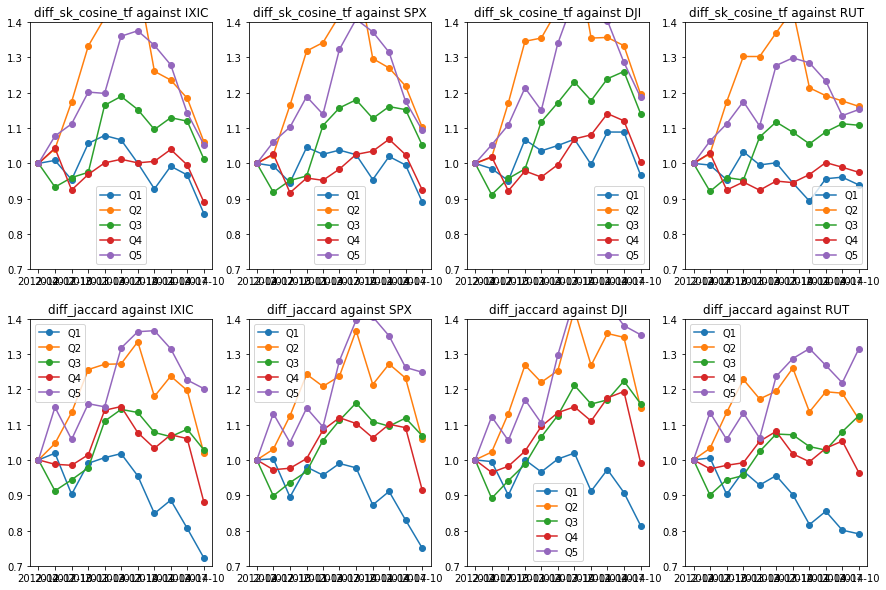

In [48]:
ylim = [0.7, 1.4]
fig, ax = plt.subplots(len(s['diff_metrics']), len(index_data), figsize=(15, 10))
for idx_x, m in enumerate(s['diff_metrics']):
    for idx_y, index_name in enumerate(index_data):
        benchmark, bin_data = diff_vs_benchmark_ns(pf_values, index_name, index_data, m, s, norm_by_index=True)
        display.update_ax_diff_vs_benchmark(ax[idx_x, idx_y], benchmark, bin_data, index_name, s, ylim, m)

start = s['time_range'][0]   
end = s['time_range'][1]
plt.savefig(os.path.join(s['path_output_folder'], '{}Q{}_{}Q{}_{}_{}_sw-{}_lem-{}.png'
                         .format(str(start[0])[2:], start[1], 
                                 str(end[0])[2:], end[1],
                                 s['differentiation_mode'][0], s['pf_balancing'][0],
                                 int(s['stop_words']), int(s['lemmatize']))))
if display.run_from_ipython():
    plt.show()
else:
    plt.close(fig)

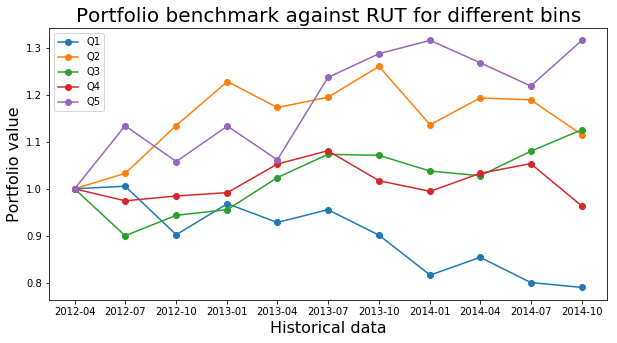

In [49]:
index_name = 'RUT'
diff_method = 'diff_sk_cosine_tf_idf'
diff_method = 'diff_jaccard'
# diff_method='diff_gfg_editDistDP'
benchmark, bin_data = diff_vs_benchmark_ns(pf_values, index_name, index_data, diff_method, s, norm_by_index=True)
display.plot_diff_vs_benchmark(benchmark, bin_data, index_name, s)

# Display the data

## For a given ticker

### Metrics vs stock price

In [50]:
benchmark, metric_data = display.diff_vs_stock(extracted_cik_scores, extracted_stock_data, ticker, s, method='diff')
display.plot_diff_vs_stock(benchmark, metric_data, ticker, s)

NameError: name 'extracted_cik_scores' is not defined

### Sentiment vs stock price

In [ ]:
benchmark, metric_data = display.diff_vs_stock(extracted_cik_scores, extracted_stock_data, ticker, s, method='sentiment')
display.plot_diff_vs_stock(benchmark, metric_data, ticker, s, method='sentiment')